# Load dataset

In [1]:
raw_data = read.csv("final_cleaned_data.csv")

### Make a copy, just so we keep the raw data untouched 

In [2]:
filtered_data = data.frame(raw_data)

### Filter out annual and bianuual seasonalites (by using a band filter)

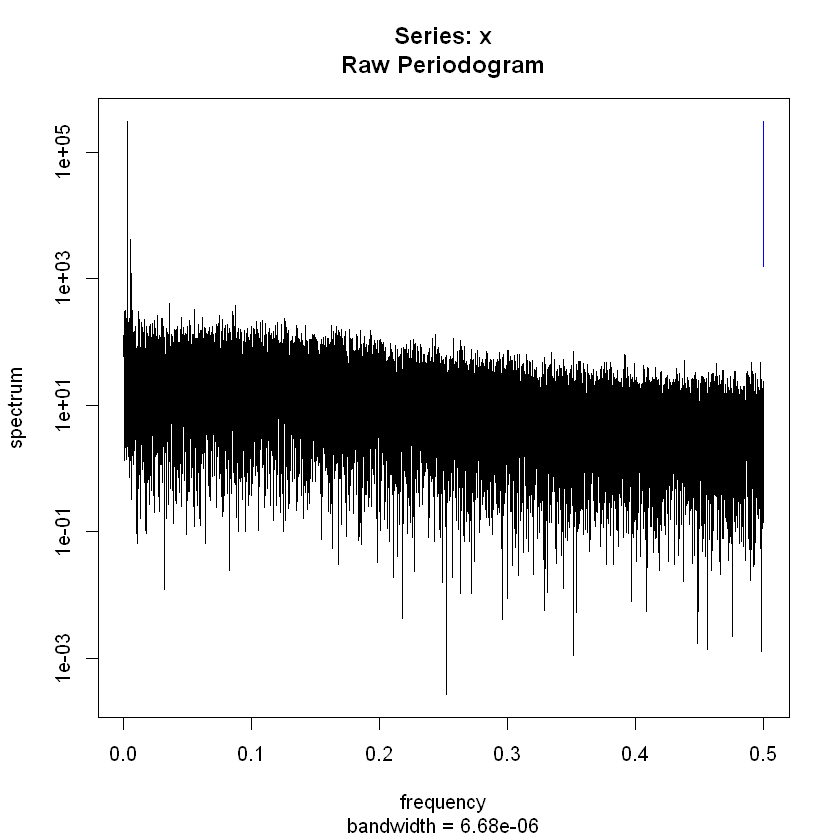

In [3]:
spectrum(filtered_data$MaxTemp)

Clearly there are a few spikes indicating strong annual and biannual seasonality.

In [4]:
# Oscillations to be subtracted
annual_osc = spectral::filter.fft(filtered_data$MaxTemp, x = NULL, fc = 0.002725, BW = 0.00105, n = 2)
biannual_osc = spectral::filter.fft(filtered_data$MaxTemp, x = NULL, fc = 0.00545, BW = 0.0002, n = 2)

# This is for recovering original data
imaginary_residuals = Im(filtered_data$MaxTemp - annual_osc - biannual_osc)

# This is for further processing
filtered_data$MaxTemp = Re(filtered_data$MaxTemp - annual_osc - biannual_osc)

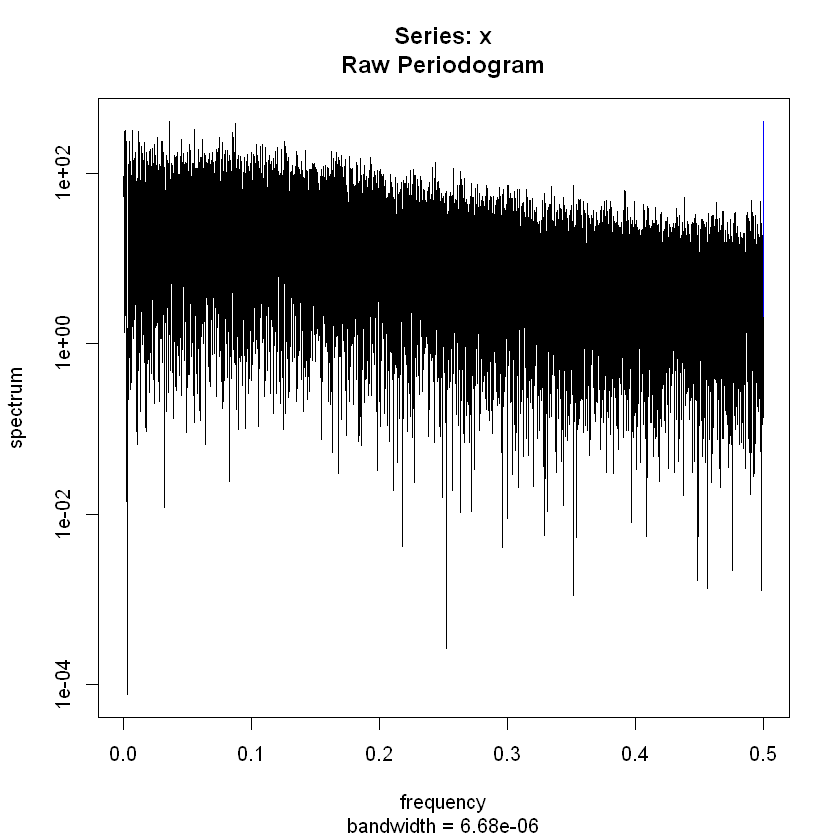

In [5]:
spectrum(filtered_data$MaxTemp)

Successful! 

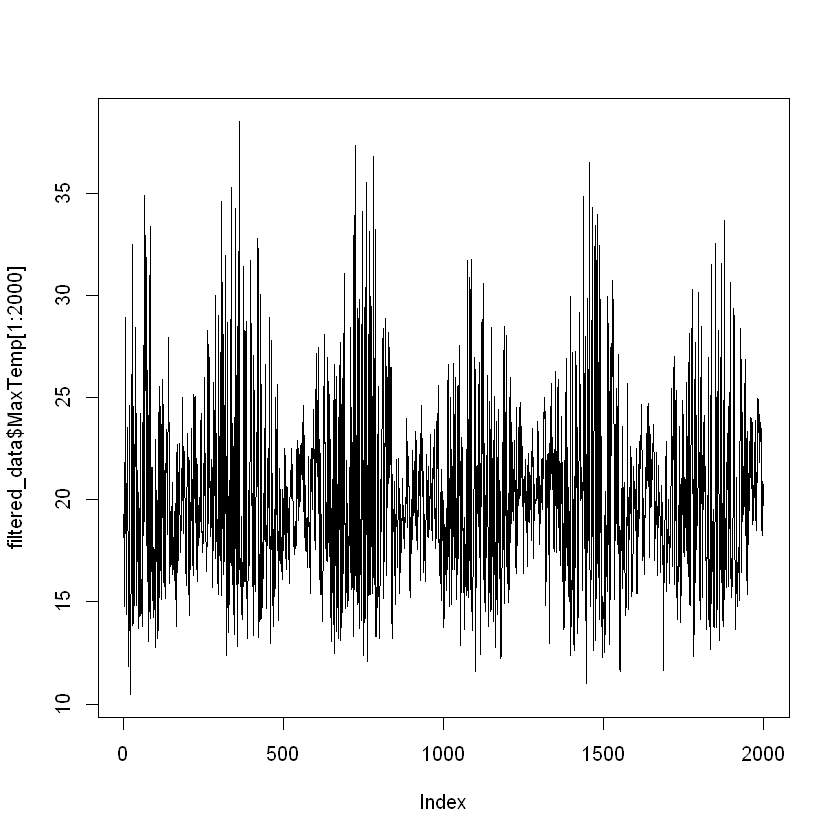

In [6]:
plot(filtered_data$MaxTemp[1:2000], type = 'l')

Varying variance, but seems to be periodic and dependent on time!

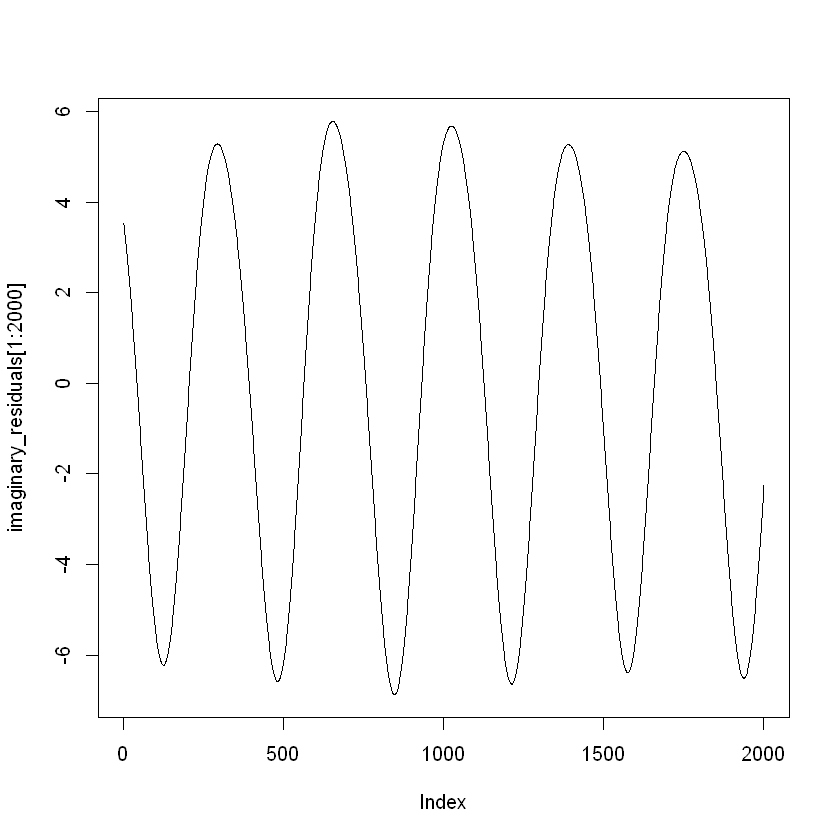

In [7]:
plot(imaginary_residuals[1:2000], type = 'l')

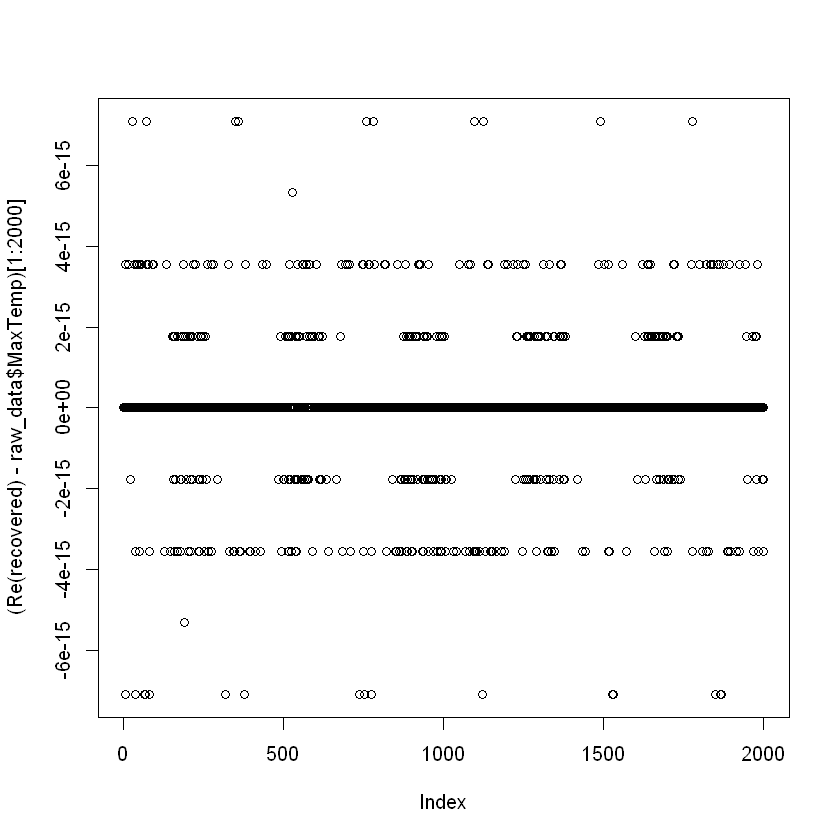

In [8]:
recovered = complex(imaginary = imaginary_residuals, real = filtered_data$MaxTemp) + annual_osc + biannual_osc
plot((Re(recovered) - raw_data$MaxTemp)[1:2000])

Good! When we try to recover the original data, the error between recovered vs raw is very small! 

# Approach 1: Group by day

From previous visualizations, we note that the variance of our time series seems to be dependent on time. 

In [9]:
daily_normalized_data = data.frame(filtered_data)

In [10]:
grouped_daily_var = aggregate(MaxTemp ~ Month*Day, daily_normalized_data, FUN = var)
grouped_daily_var = grouped_daily_var[order(grouped_daily_var$Month, grouped_daily_var$Day), ]
grouped_daily_avg = aggregate(MaxTemp ~ Month*Day, daily_normalized_data, FUN = mean)
grouped_daily_avg = grouped_daily_avg[order(grouped_daily_avg$Month, grouped_daily_avg$Day), ]

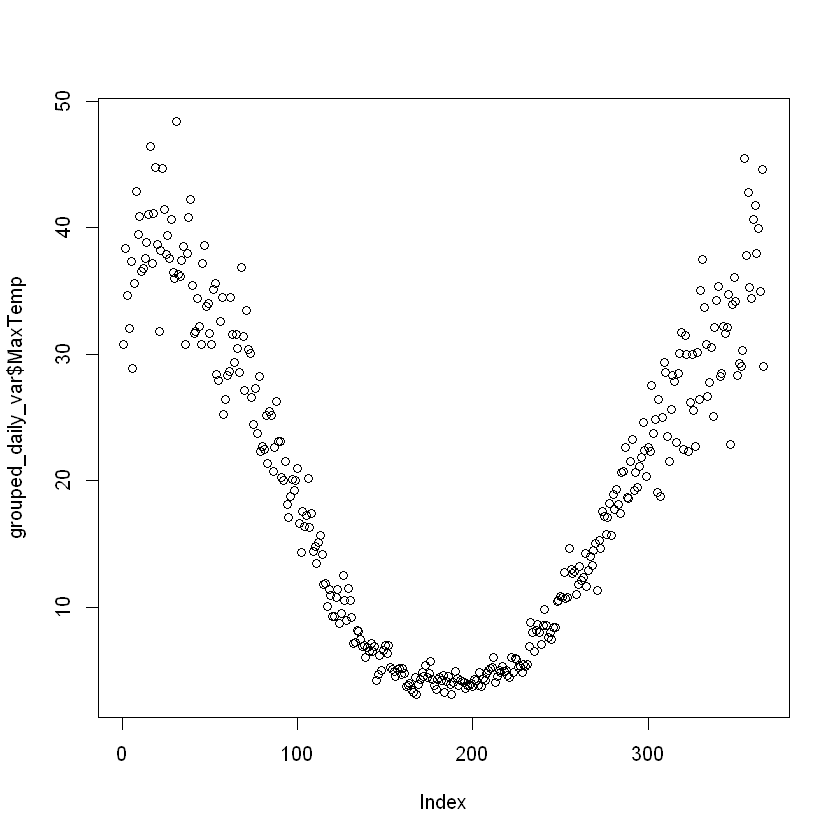

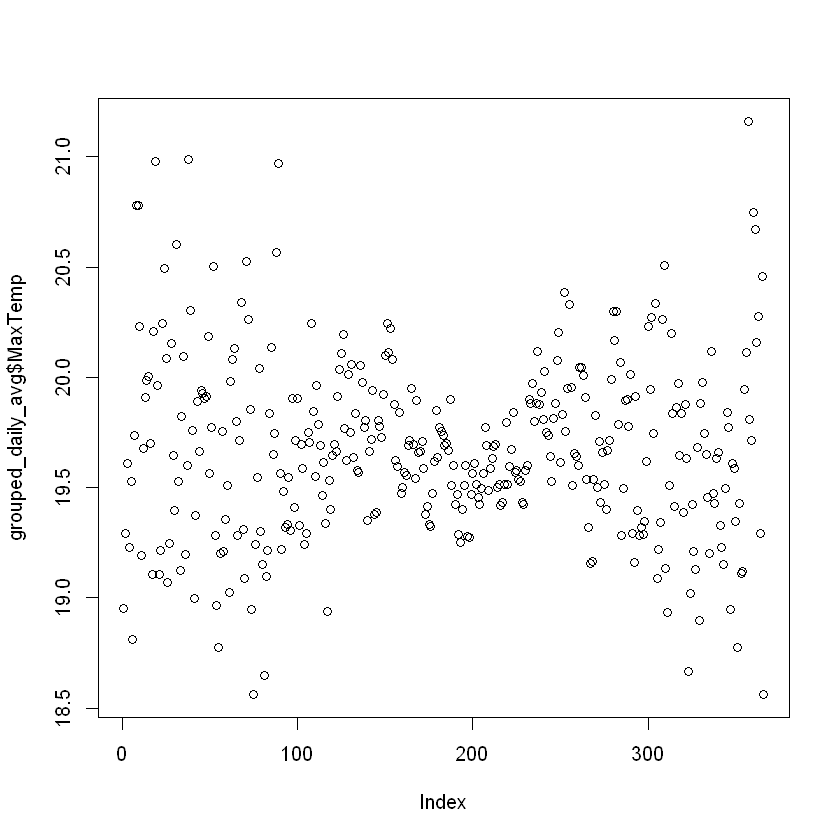

In [11]:
plot(grouped_daily_var$MaxTemp)
plot(grouped_daily_avg$MaxTemp)

## Using for loop to normalize the data

In [12]:
for (row in c(1: nrow(daily_normalized_data))){
    month = daily_normalized_data[row, 2]
    day = daily_normalized_data[row, 3]
    variance = grouped_daily_var[ which(grouped_daily_var$Month == month & grouped_daily_var$Day == day), ]$MaxTemp
    mean = grouped_daily_avg[ which(grouped_daily_avg$Month == month & grouped_daily_avg$Day == day), ]$MaxTemp
    daily_normalized_data[row, 4] = (daily_normalized_data[row, 4] - mean )/ sqrt(variance)
}

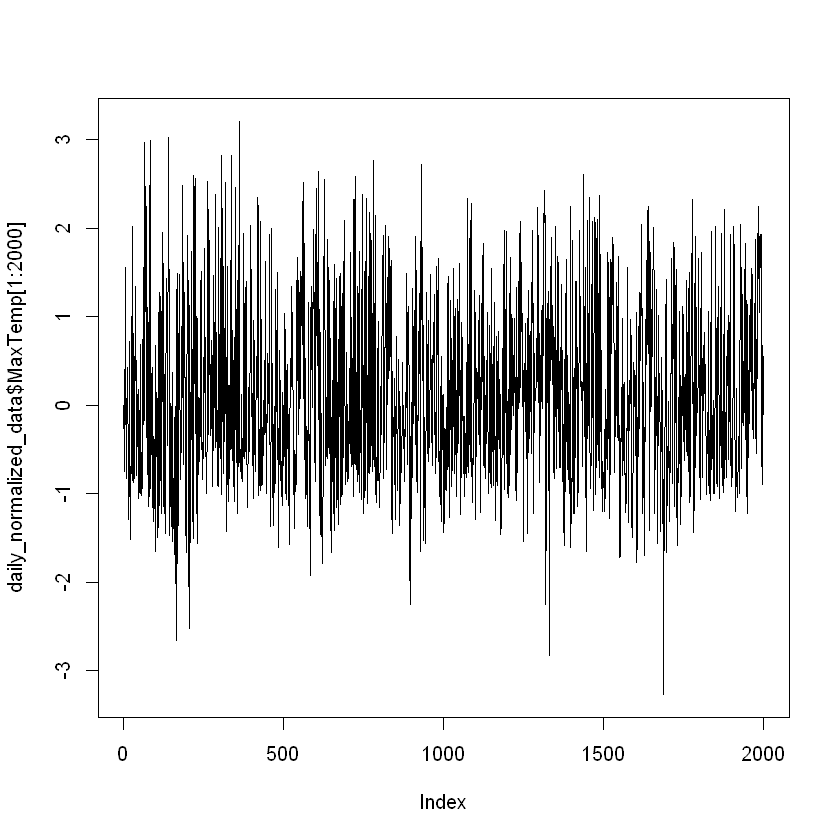

In [13]:
plot(daily_normalized_data$MaxTemp[1:2000], type = 'l')

We seem to be able to reduce some of the variance, but regular spikes are still clearly visible.

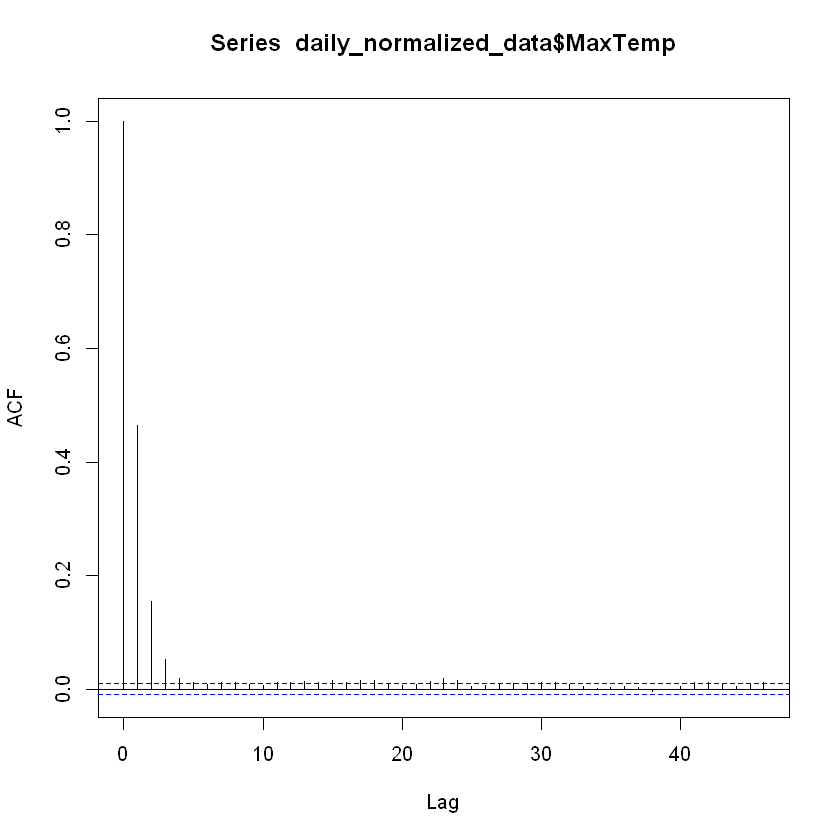

In [14]:
acf(daily_normalized_data$MaxTemp)

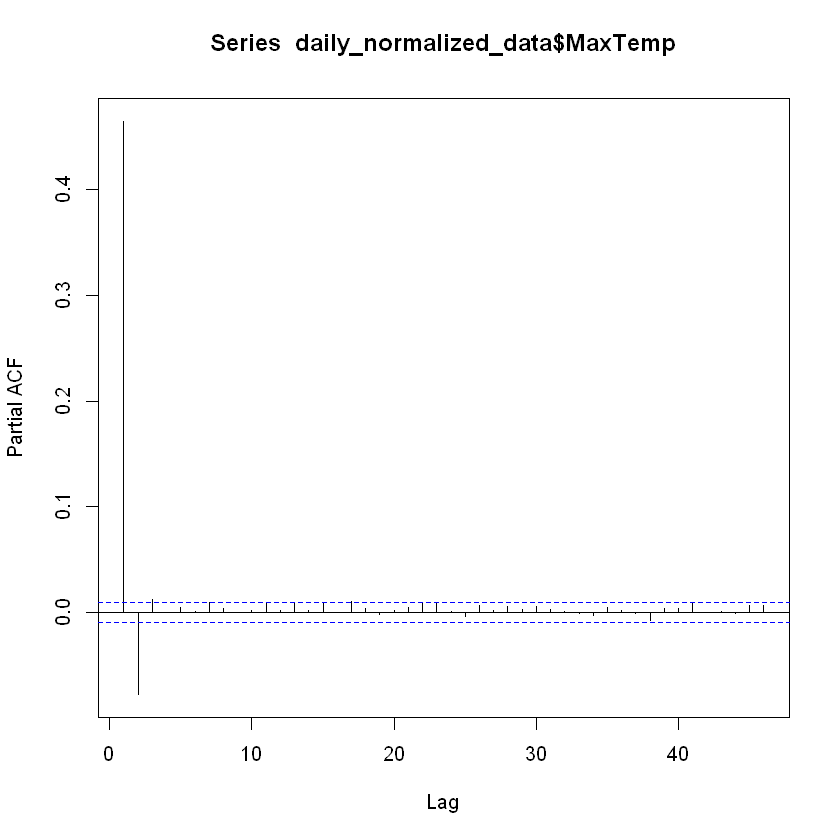

In [15]:
pacf(daily_normalized_data$MaxTemp)

# Approach 2: Group by month

In [15]:
monthly_normalized_data = data.frame(filtered_data)

In [16]:
rm(mean)

grouped_monthly_var = aggregate(MaxTemp ~ Month, monthly_normalized_data, FUN = var)
grouped_monthly_var = grouped_monthly_var[order(grouped_monthly_var$Month), ]
grouped_monthly_avg = aggregate(MaxTemp ~ Month, monthly_normalized_data, FUN = mean)
grouped_monthly_avg = grouped_monthly_avg[order(grouped_monthly_avg$Month), ]

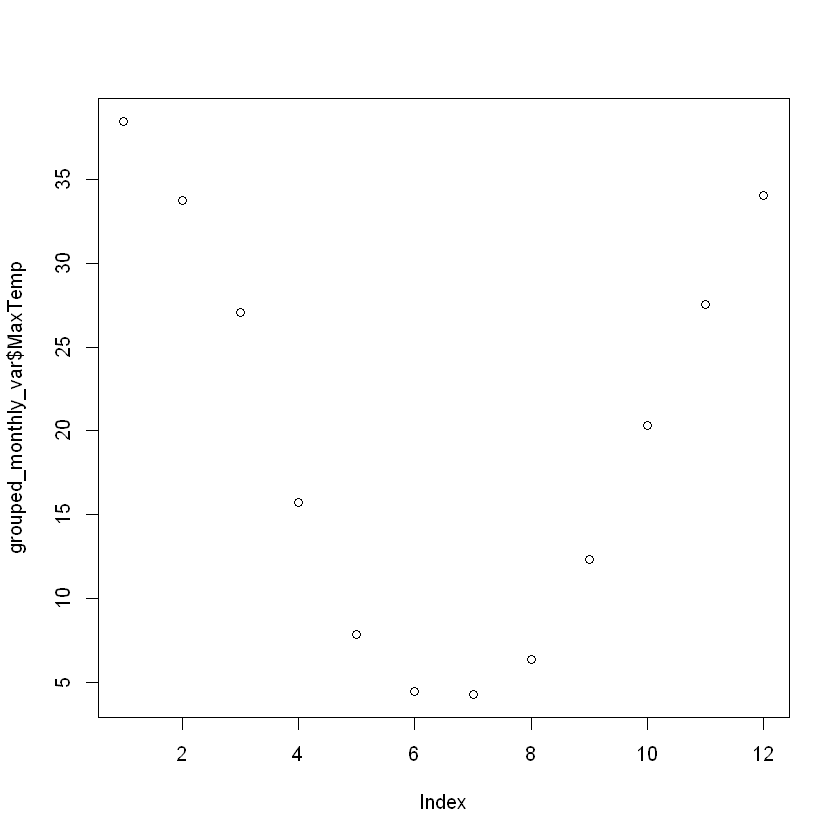

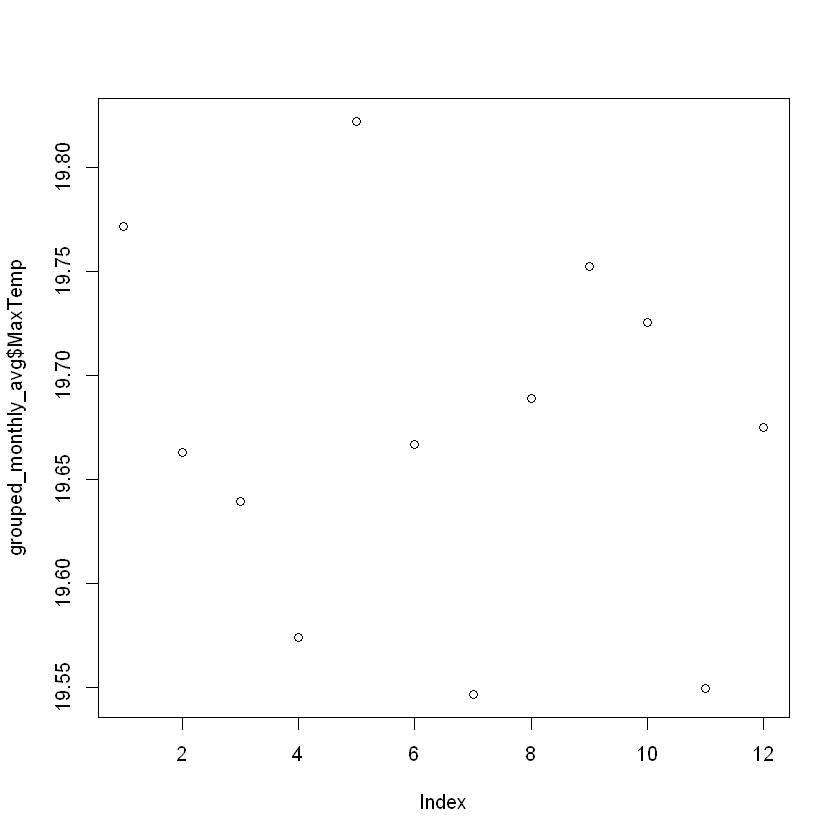

In [17]:
plot(grouped_monthly_var$MaxTemp)
plot(grouped_monthly_avg$MaxTemp)

## Using for loop to normalize the data

In [18]:
for (row in c(1: nrow(monthly_normalized_data))){
    month = monthly_normalized_data[row, 2]
    variance = grouped_monthly_var[ which(grouped_monthly_var$Month == month), ]$MaxTemp
    mean = grouped_monthly_avg[ which(grouped_monthly_avg$Month == month), ]$MaxTemp
    monthly_normalized_data[row, 4] = (monthly_normalized_data[row, 4] - mean )/ sqrt(variance)
}

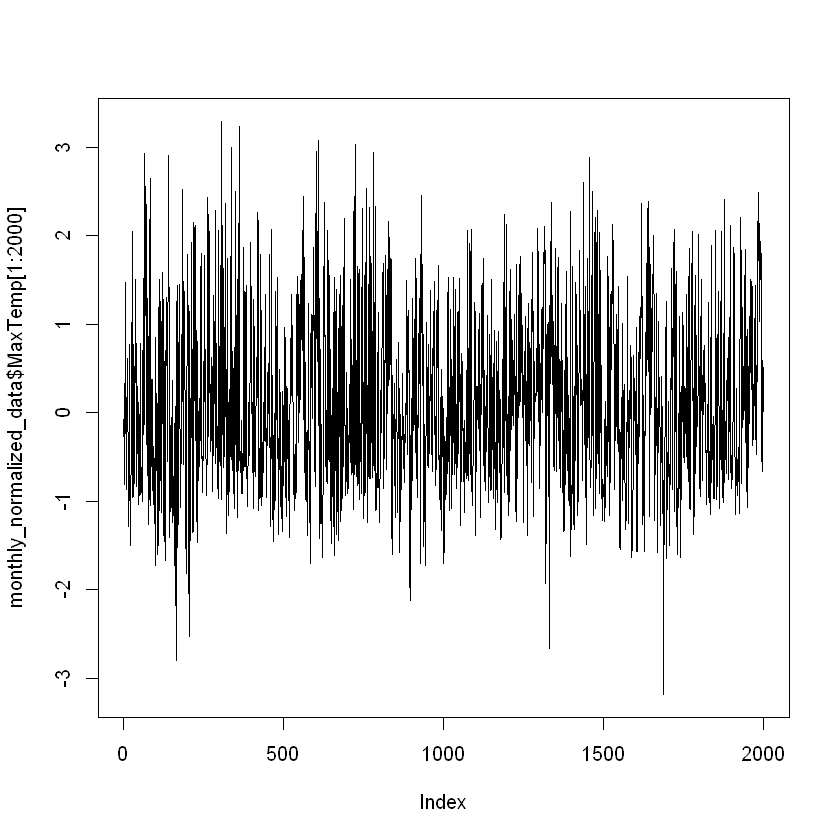

In [19]:
plot(monthly_normalized_data$MaxTemp[1:2000], type = 'l')

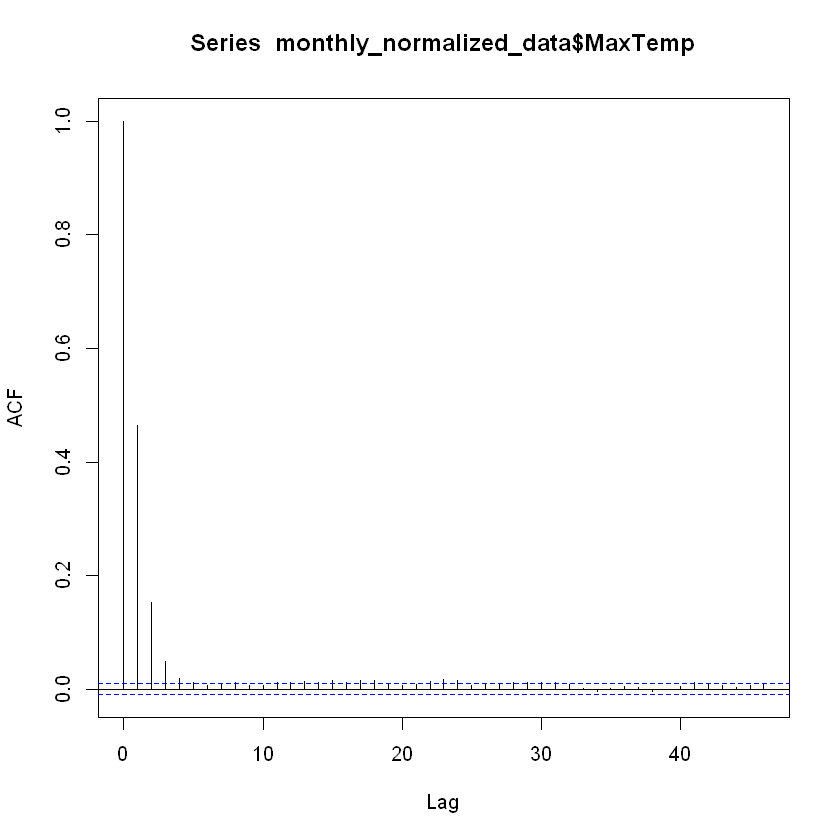

In [20]:
acf(monthly_normalized_data$MaxTemp)

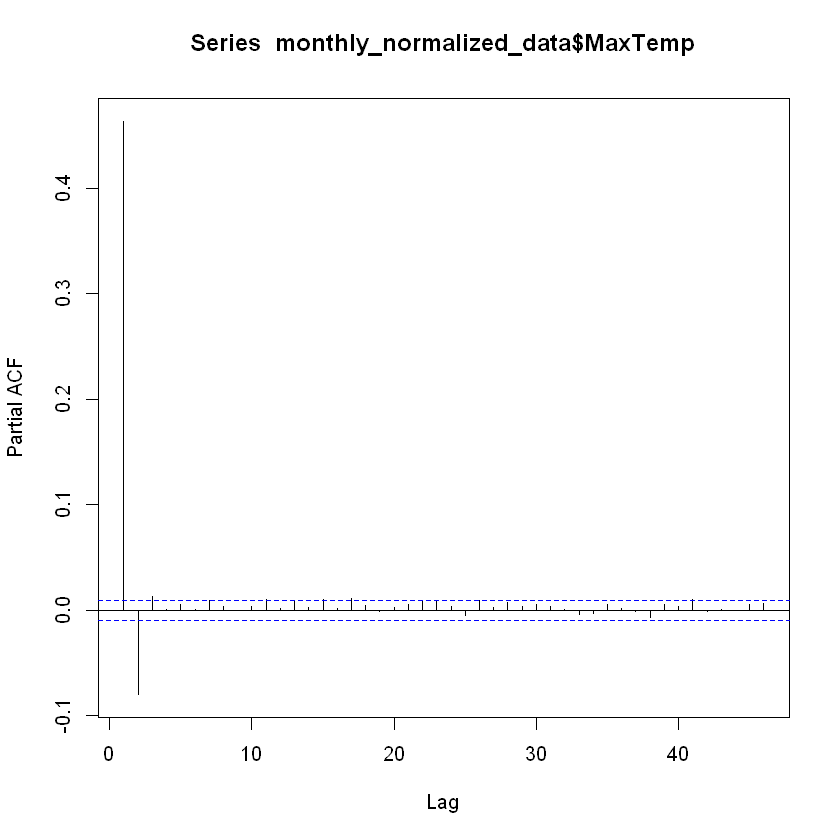

In [21]:
pacf(monthly_normalized_data$MaxTemp)

# Approach 3: Normalize using daily mean and monthly variance

In [27]:
daily_monthly_normalized_data = data.frame(filtered_data)

In [28]:
for (row in c(1: nrow(daily_monthly_normalized_data))){
    month = daily_monthly_normalized_data[row, 2]
    day = daily_monthly_normalized_data[row, 3]
    variance = grouped_daily_var[ which(grouped_daily_var$Month == month & grouped_daily_var$Day == day), ]$MaxTemp
    mean = grouped_monthly_avg[ which(grouped_monthly_avg$Month == month), ]$MaxTemp
    daily_monthly_normalized_data[row, 4] = (daily_monthly_normalized_data[row, 4] - mean )/ sqrt(variance)
}

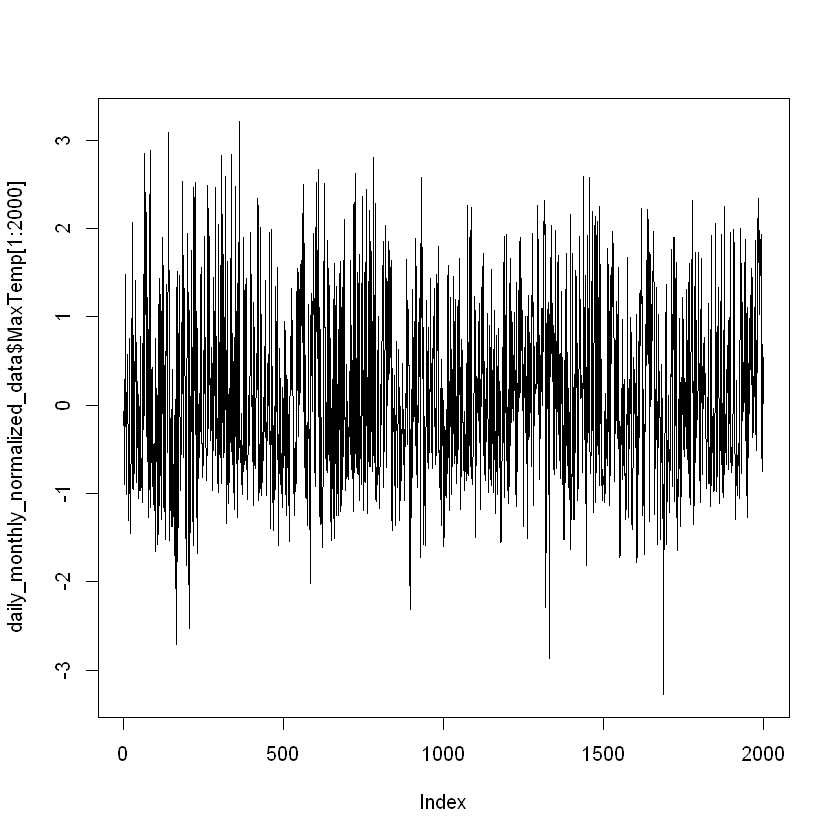

In [36]:
plot(daily_monthly_normalized_data$MaxTemp[1:2000], type = 'l')

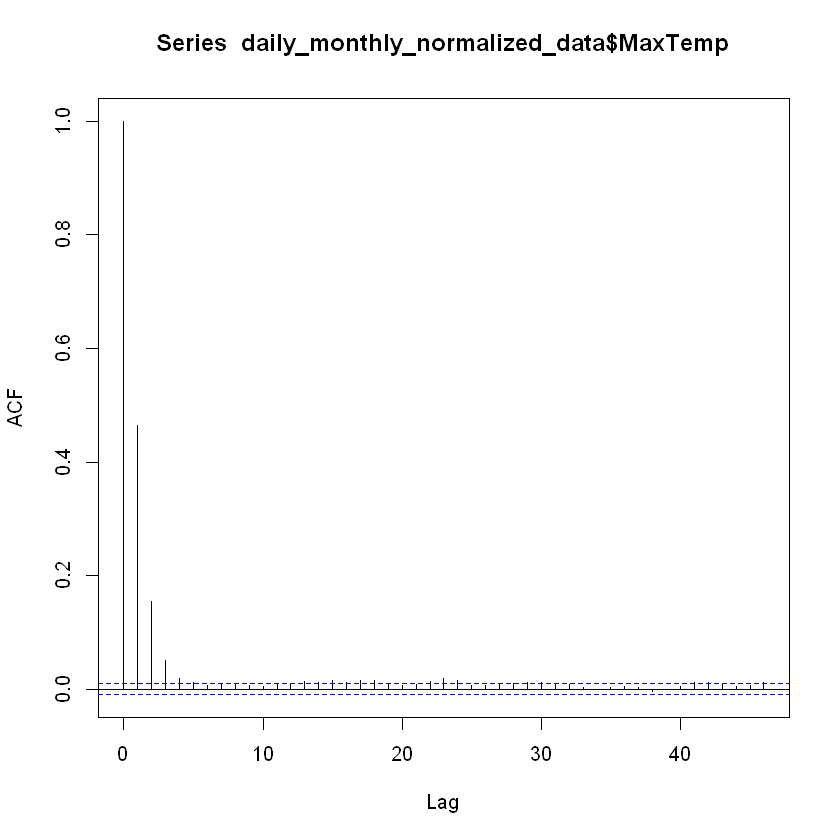

In [146]:
acf(daily_monthly_normalized_data$MaxTemp)

In [31]:
install.packages("roll", repos = "http://cran.us.r-project.org") 

Installing package into 'C:/Users/emara/Documents/R/win-library/3.4'
(as 'lib' is unspecified)


package 'roll' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\emara\AppData\Local\Temp\RtmpwxFLlm\downloaded_packages


# Evaluation

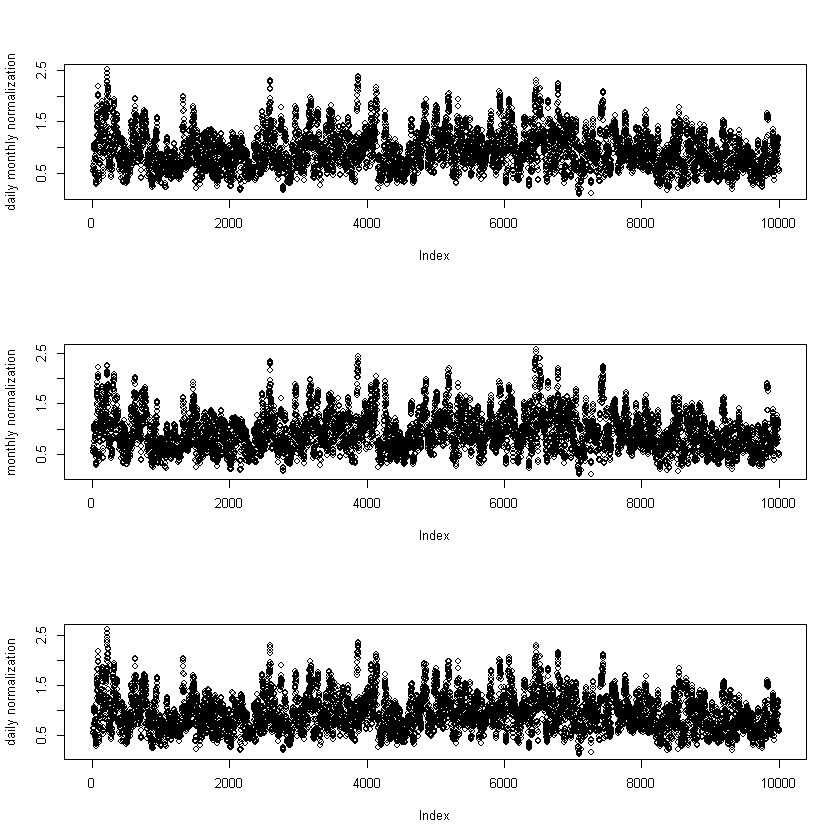

In [34]:
layout(matrix(3:1,nrow=3))
plot(roll::roll_var(matrix(daily_normalized_data$MaxTemp[1:10000]), width = 21), ylab = "daily normalization")
plot(roll::roll_var(matrix(monthly_normalized_data$MaxTemp[1:10000]), width = 21), ylab = "monthly normalization")
plot(roll::roll_var(matrix(daily_monthly_normalized_data$MaxTemp[1:10000]), width = 21), ylab = "daily monthly normalization")

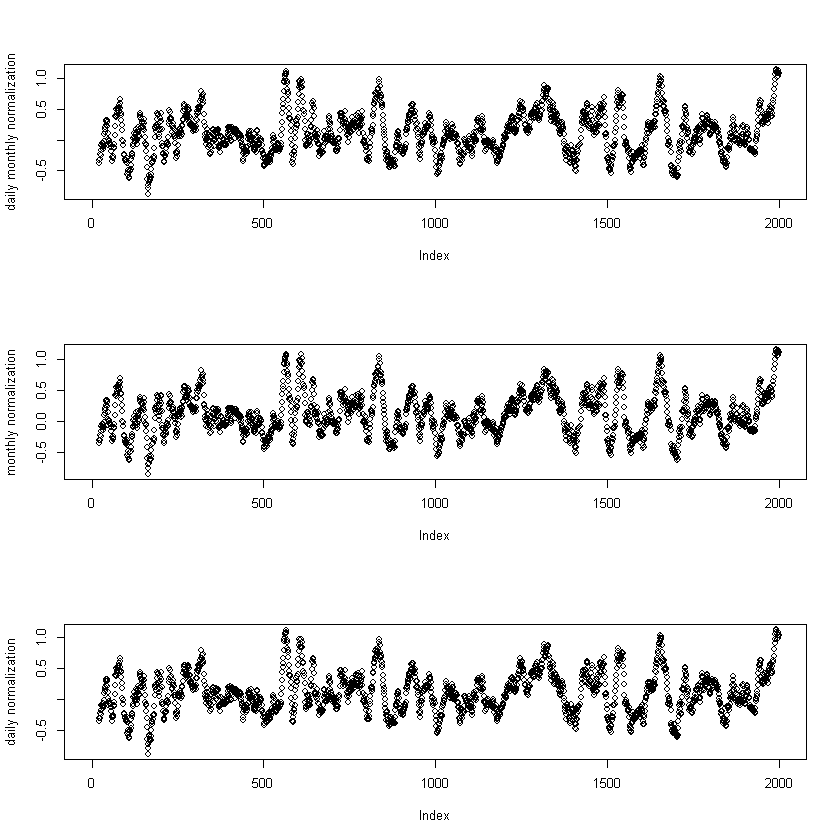

In [33]:
layout(matrix(3:1,nrow=3))
plot(roll::roll_mean(matrix(daily_normalized_data$MaxTemp[1:2000]), width = 21), ylab = "daily normalization")
plot(roll::roll_mean(matrix(monthly_normalized_data$MaxTemp[1:2000]), width = 21), ylab = "monthly normalization")
plot(roll::roll_mean(matrix(daily_monthly_normalized_data$MaxTemp[1:2000]), width = 21), ylab = "daily monthly normalization")

Best one seems to be monthly normalization, by a very small margin. 

# Fitting a model to the remainder
## AR(2)

In [21]:
ts = ts(daily_normalized_data$MaxTemp, frequency = 365)
head(ts)

[1] -0.004104783 -0.517039328 -0.171338183 -0.752515227  1.552664123
[6] -0.213510811

In [22]:
ts_lag1 = lag(ts,-1) 
ts_lag2 = lag(ts,-2) 
ts_lag3 = lag(ts,-3) 
ts_lag4 = lag(ts,-4) 
ts_lag5 = lag(ts,-5) 
ts_lag6 = lag(ts,-6)
ts_lag7 = lag(ts,-7)
ts_lag8 = lag(ts,-8) 
ts_lag9 = lag(ts,-9) 
ts_lag10 = lag(ts,-10) 
ts_lag11 = lag(ts,-11) 
ts_lag12 = lag(ts,-12) 
ts_lag13 = lag(ts,-13) 
ts_lag14 = lag(ts,-14) 

In [23]:
y = cbind(ts, ts_lag1)
y = cbind(y, ts_lag2)
y = cbind(y, ts_lag3)
y = cbind(y, ts_lag4)
y = cbind(y, ts_lag5)
y = cbind(y, ts_lag6)
y = cbind(y, ts_lag7)
y = cbind(y, ts_lag8)
y = cbind(y, ts_lag9)
y = cbind(y, ts_lag10)
y = cbind(y, ts_lag11)
y = cbind(y, ts_lag12)
y = cbind(y, ts_lag13)
y = cbind(y, ts_lag14)

In [24]:
head(y)

y.y.y.y.y.y.y.y.y.y.y.y.y.ts,y.y.y.y.y.y.y.y.y.y.y.y.y.ts_lag1,y.y.y.y.y.y.y.y.y.y.y.y.ts_lag2,y.y.y.y.y.y.y.y.y.y.y.ts_lag3,y.y.y.y.y.y.y.y.y.y.ts_lag4,y.y.y.y.y.y.y.y.y.ts_lag5,y.y.y.y.y.y.y.y.ts_lag6,y.y.y.y.y.y.y.ts_lag7,y.y.y.y.y.y.ts_lag8,y.y.y.y.y.ts_lag9,y.y.y.y.ts_lag10,y.y.y.ts_lag11,y.y.ts_lag12,y.ts_lag13,ts_lag14
-0.004104783,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
-0.517039328,-0.004104783,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
-0.171338183,-0.517039328,-0.004104783,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
-0.752515227,-0.171338183,-0.517039328,-0.004104783,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1.552664123,-0.752515227,-0.171338183,-0.517039328,-0.004104783,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
-0.213510811,1.552664123,-0.752515227,-0.171338183,-0.517039328,-0.004104783,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [25]:
ar1fit = lm(y[,1] ~ y[,2])
ar2fit = lm(y[,1] ~ y[,2] + y[,3])
ar3fit = lm(y[,1] ~ y[,2] + y[,3] + y[, 4])
# complex_model = lm(y[,1] ~ (y[,2] + y[,3] + y[, 4] + y[, 5] + y[, 6] + y[, 7] + y[, 8] + y[, 9] + y[, 10] + y[, 11] + y[, 12] + y[, 13] +y[, 14] )^3)

In [ ]:
summary(ar2fit)

In [ ]:
summary(ar3fit)

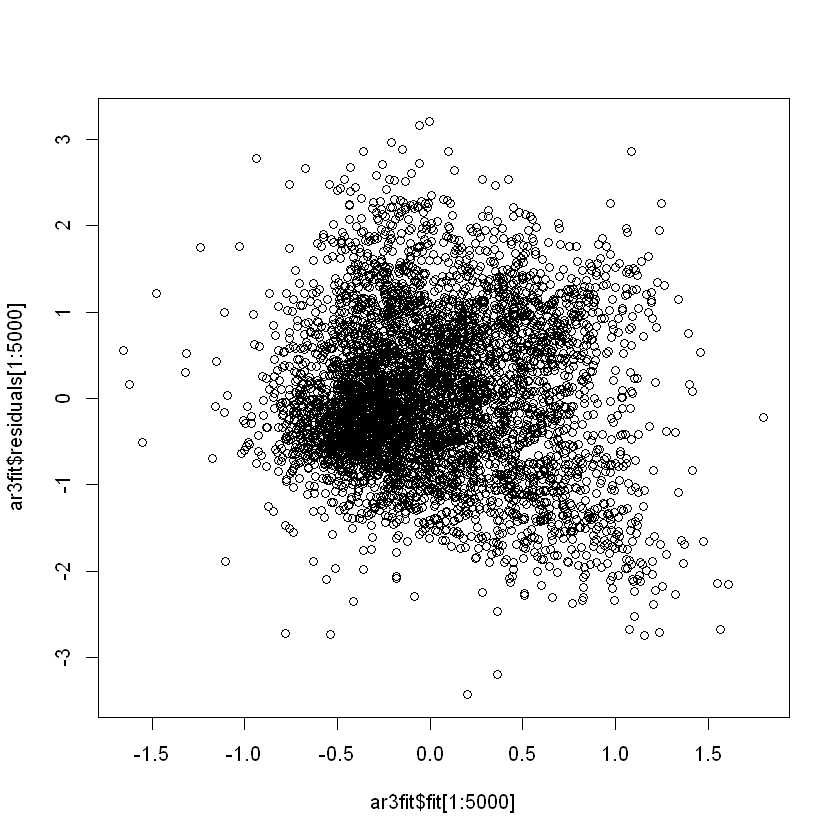

In [138]:
plot(ar3fit$fit[1:5000], ar3fit$residuals[1:5000])

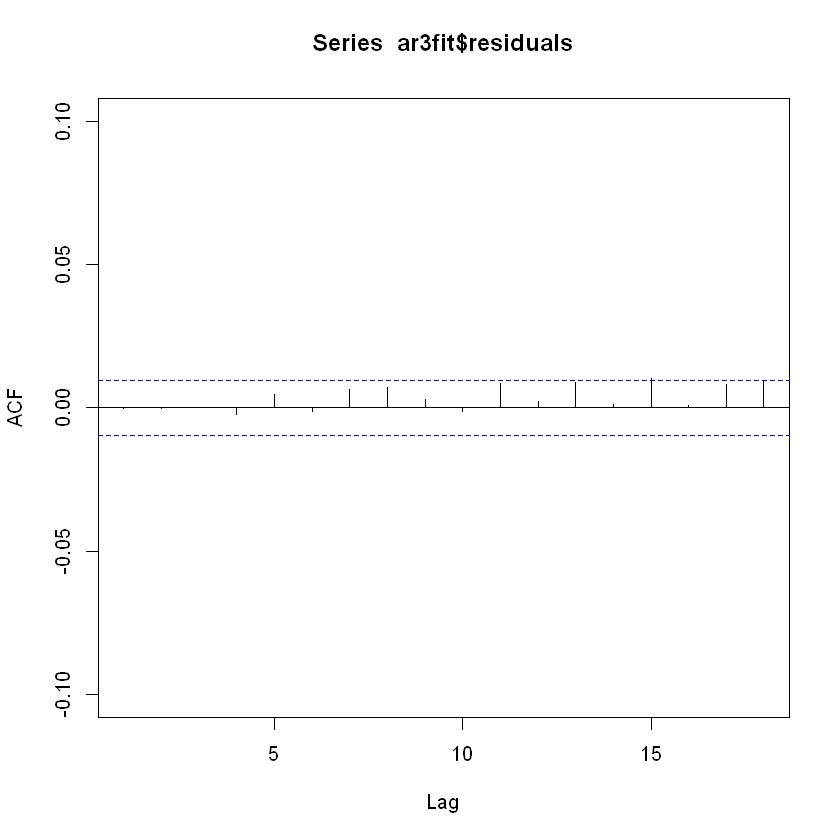

In [143]:
acf(ar3fit$residuals, xlim=c(1,18), ylim = c(-0.1, 0.1))

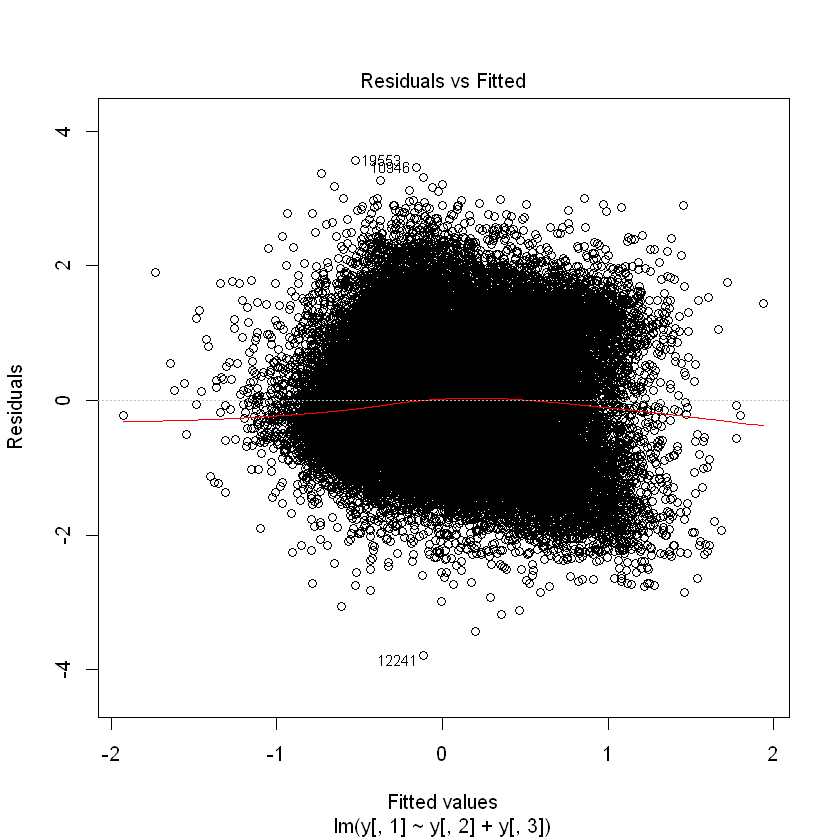

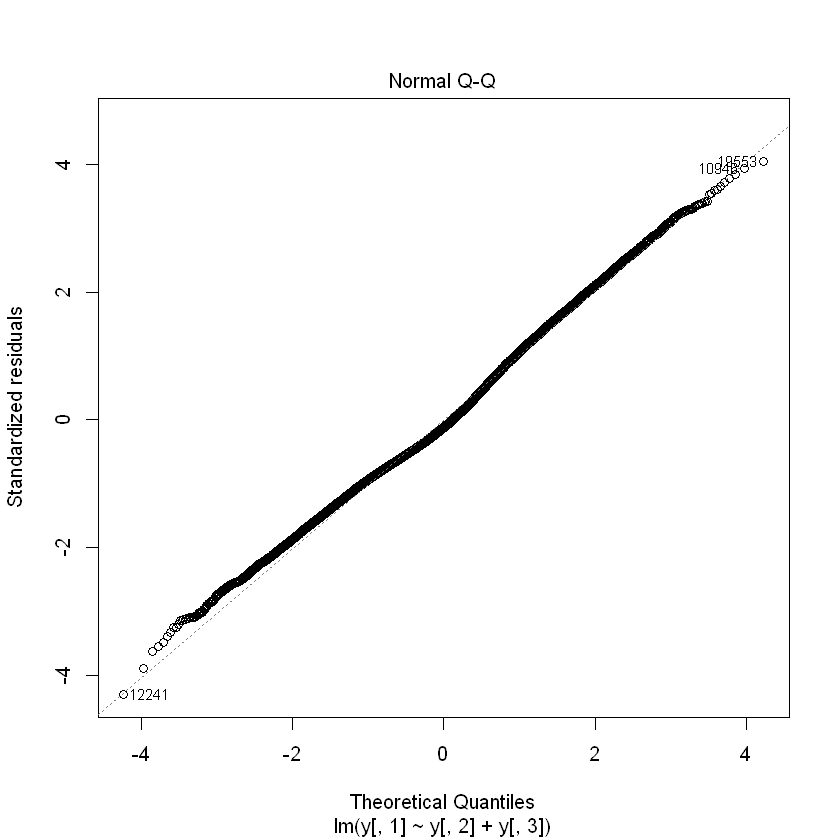

In [115]:
plot(ar2fit, which = 1)
plot(ar2fit, which = 2)

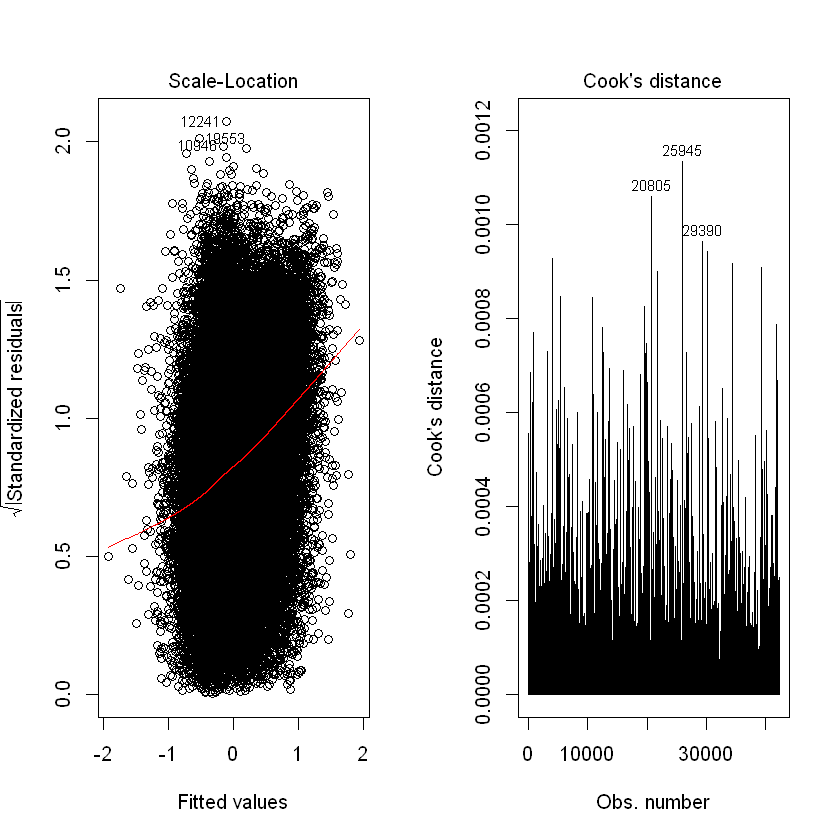

In [116]:
layout(matrix(1:2,ncol=2))
plot(ar2fit, which = 3)
plot(ar2fit, which = 4)

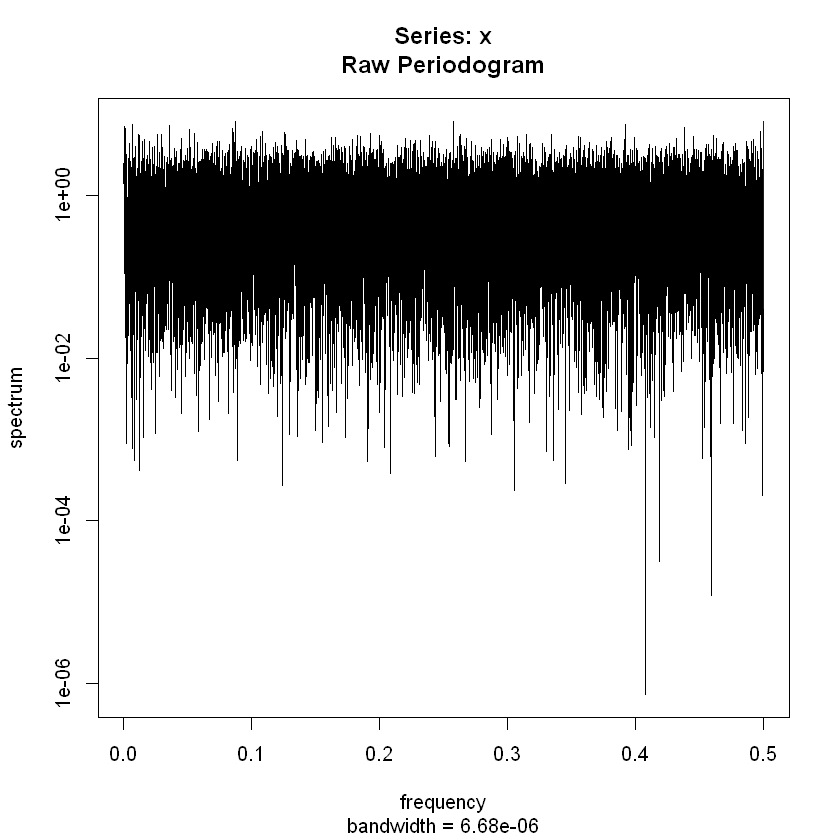

In [107]:
spectrum(ar2fit$residuals)

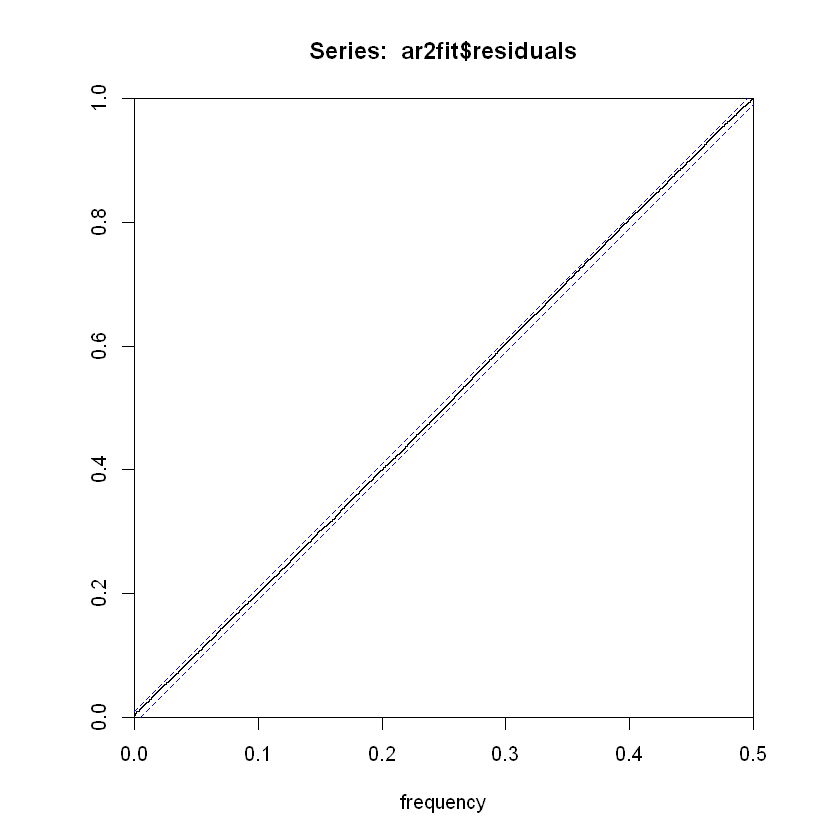

In [136]:
cpgram(ar2fit$residuals)

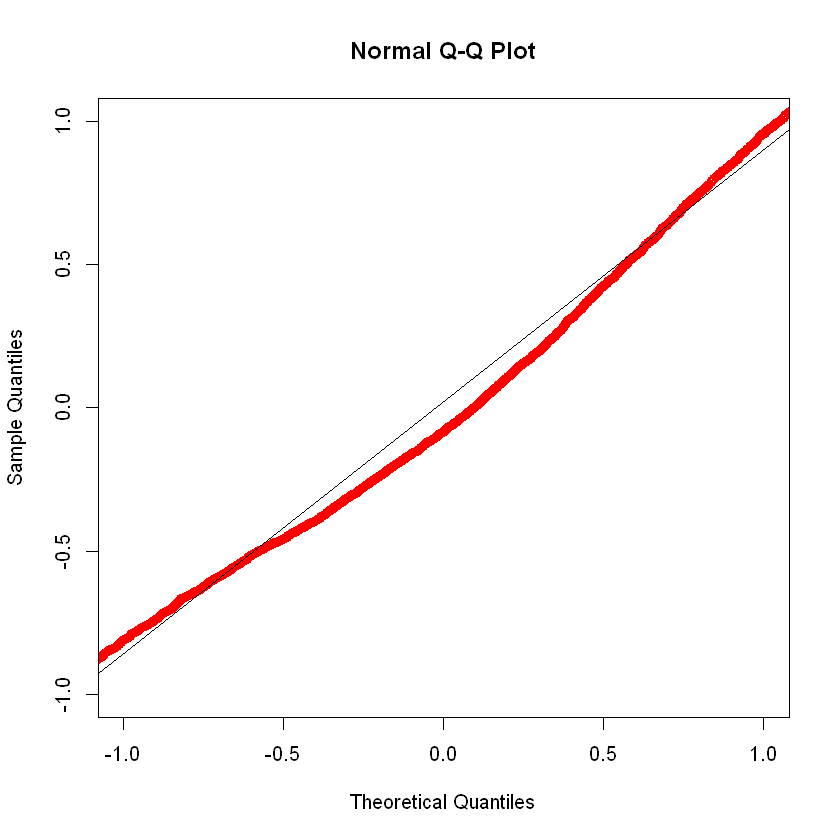

In [144]:
qqnorm(ar3fit$residuals[1:5000], col = 'red', ylim = c(-1, 1), xlim = c(-1, 1))
qqline(ar3fit$residuals[1:5000])

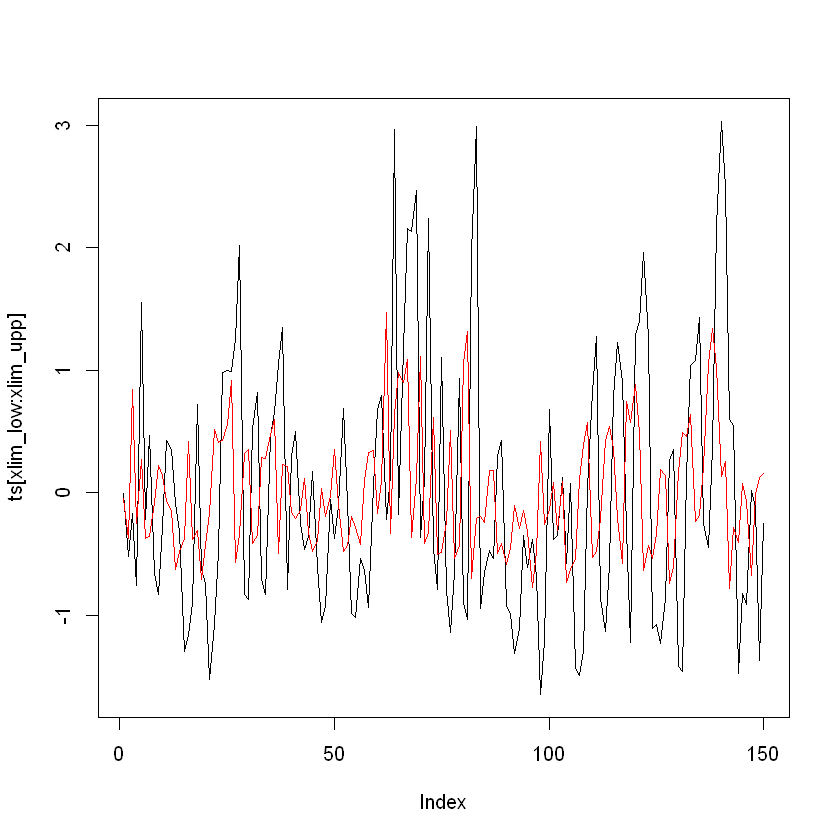

In [168]:
xlim_low = 1
xlim_upp = 150
plot(ts[xlim_low:xlim_upp], type = 'l')
lines(c(xlim_low:xlim_upp), ar3fit$fit[xlim_low:xlim_upp], col = 'red')

In [206]:
summary(complex_model)


Call:
lm(formula = y[, 1] ~ (y[, 2] + y[, 3] + y[, 4] + y[, 5] + y[, 
    6] + y[, 7] + y[, 8] + y[, 9] + y[, 10] + y[, 11] + y[, 12] + 
    y[, 13] + y[, 14])^3)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.0056 -0.5941 -0.1015  0.5916  3.5941 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              2.853e-02  7.487e-03   3.811 0.000139 ***
y[, 2]                   4.976e-01  8.137e-03  61.149  < 2e-16 ***
y[, 3]                  -7.908e-02  8.808e-03  -8.978  < 2e-16 ***
y[, 4]                   1.407e-02  8.804e-03   1.598 0.109952    
y[, 5]                  -5.735e-03  8.831e-03  -0.649 0.516093    
y[, 6]                   1.391e-02  8.823e-03   1.577 0.114807    
y[, 7]                  -1.621e-02  8.824e-03  -1.837 0.066230 .  
y[, 8]                   1.707e-02  8.833e-03   1.933 0.053282 .  
y[, 9]                   1.440e-02  8.895e-03   1.619 0.105495    
y[, 10]                 -5.175e-03  8.866e-03  -0.584 0.5

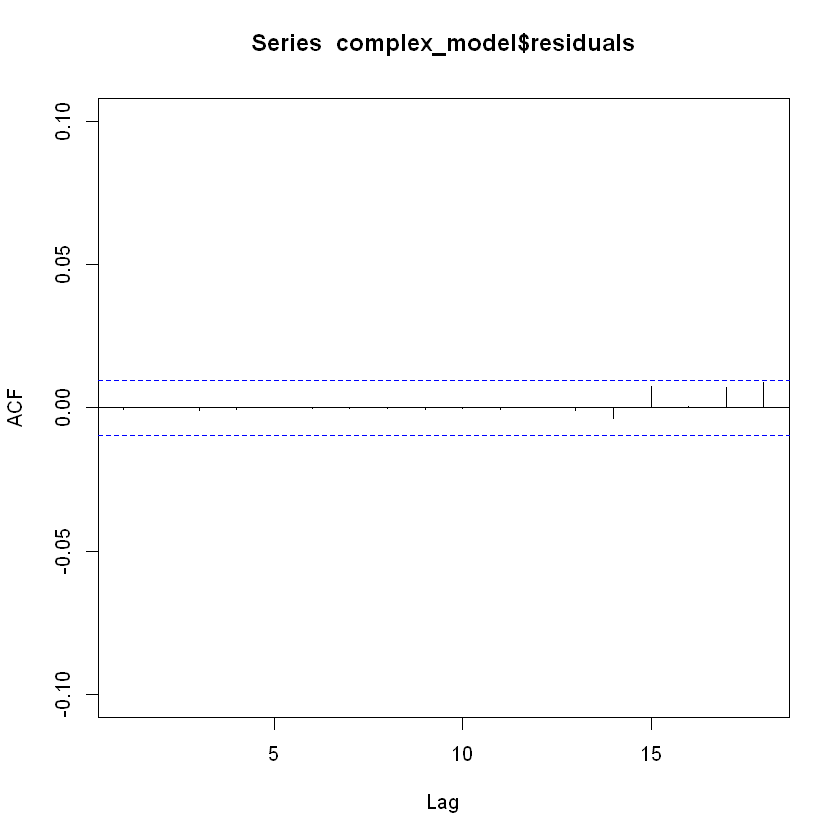

In [207]:
acf(complex_model$residuals, xlim=c(1,18), ylim = c(-0.1, 0.1))

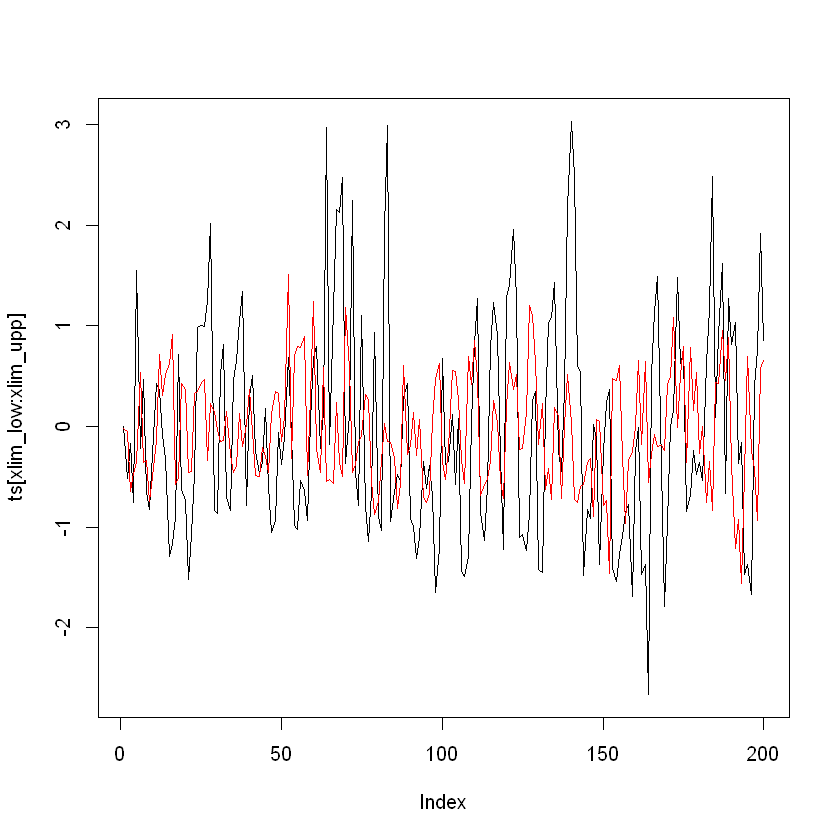

In [210]:
xlim_low = 1
xlim_upp = 200
plot(ts[xlim_low:xlim_upp], type = 'l')
lines(c(xlim_low:xlim_upp), complex_model$fit[xlim_low:xlim_upp], col = 'red')

In [204]:
sqrt(mean((complex_model$residual)^2))

[1] 0.8765334

### Modeling (revised)

In [16]:
ts = ts(daily_normalized_data$MaxTemp, frequency = 365)
head(ts)

[1] -0.004104783 -0.517039328 -0.171338183 -0.752515227  1.552664123
[6] -0.213510811

In [30]:
library(forecast)
library(ggplot2)

ar2 <- Arima(ts, order = c(2, 0, 0))
ar3 <- Arima(ts, order = c(3, 0, 0)) 

Warning message:
"package 'ggplot2' was built under R version 3.4.4"

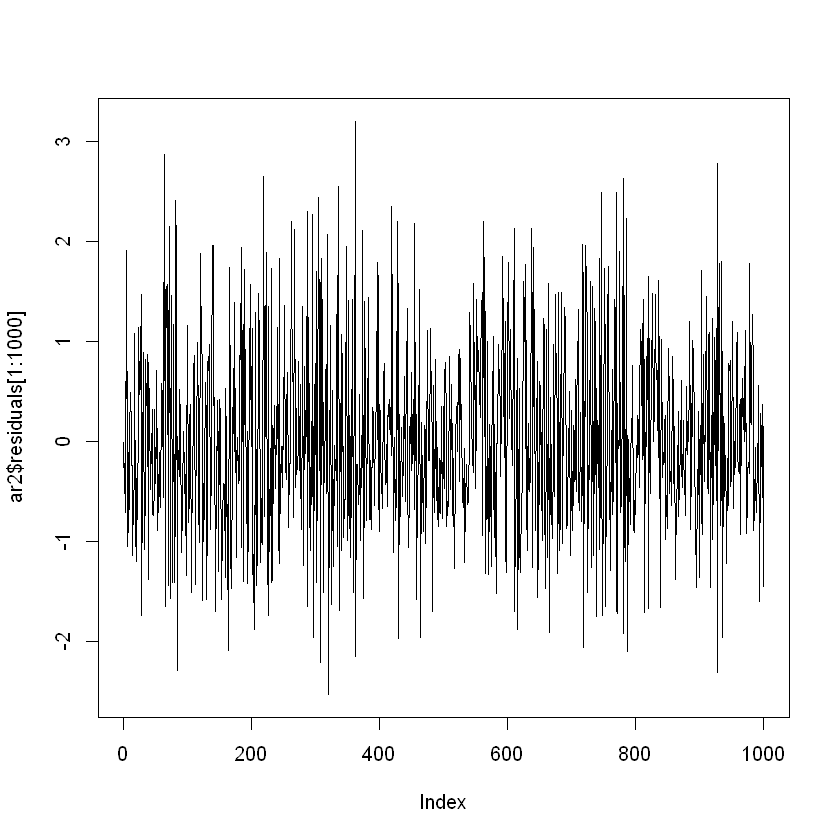

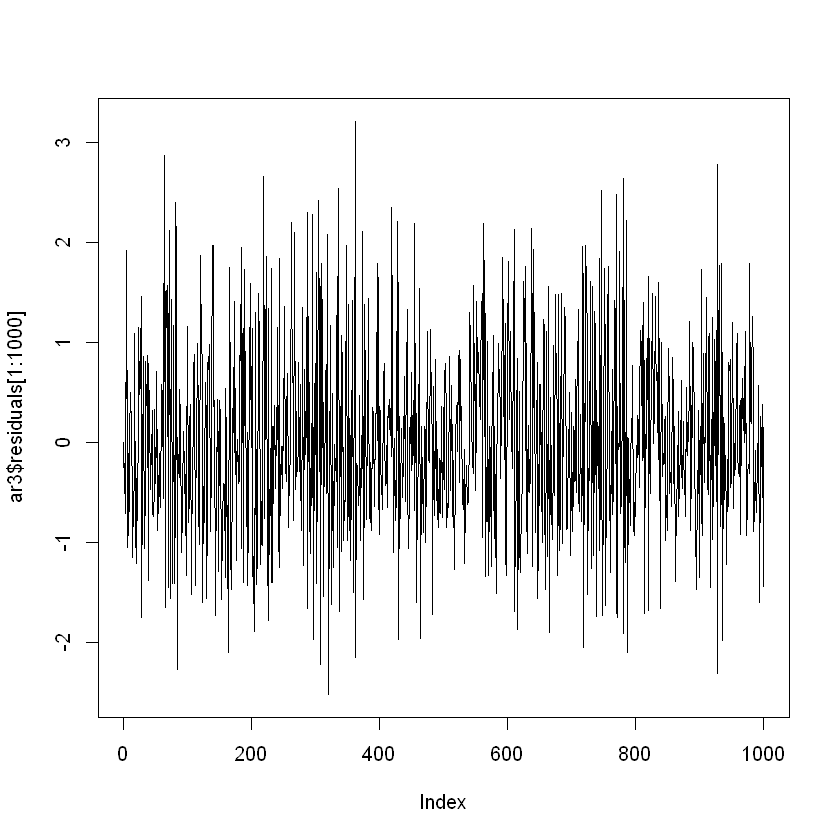

In [68]:
plot(ar2$residuals[1:1000], type = 'l')
plot(ar3$residuals[1:1000], type = 'l')

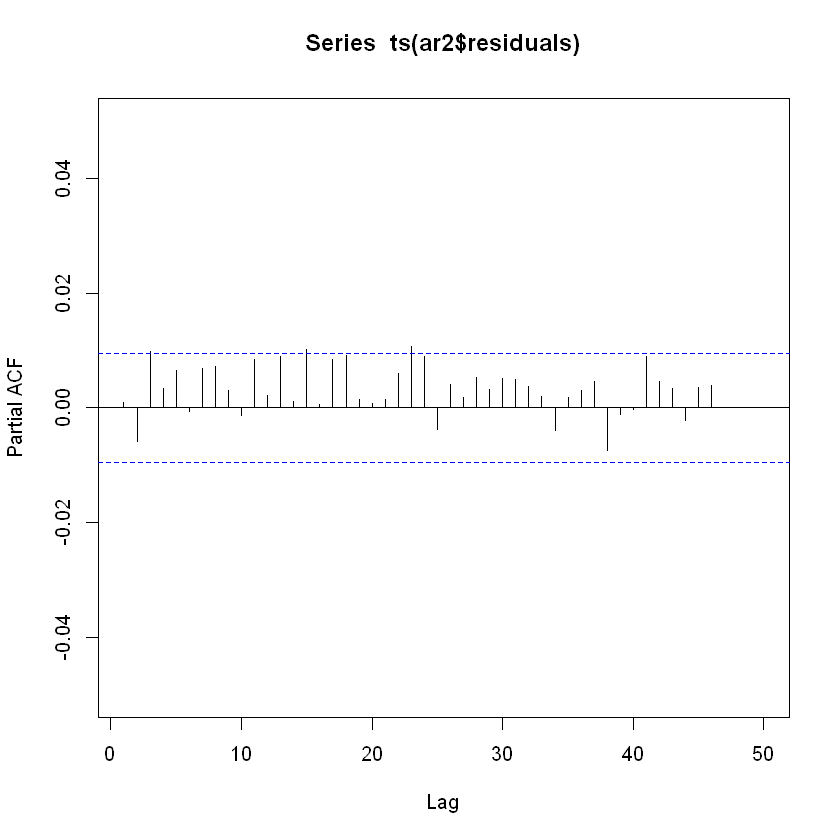

List of 6
 $ acf   : num [1:46, 1, 1] 0.001 -0.00586 0.00992 0.00338 0.00653 ...
 $ type  : chr "partial"
 $ n.used: int 42340
 $ lag   : num [1:46, 1, 1] 1 2 3 4 5 6 7 8 9 10 ...
 $ series: chr "ts(ar2$residuals)"
 $ snames: NULL
 - attr(*, "class")= chr "acf"


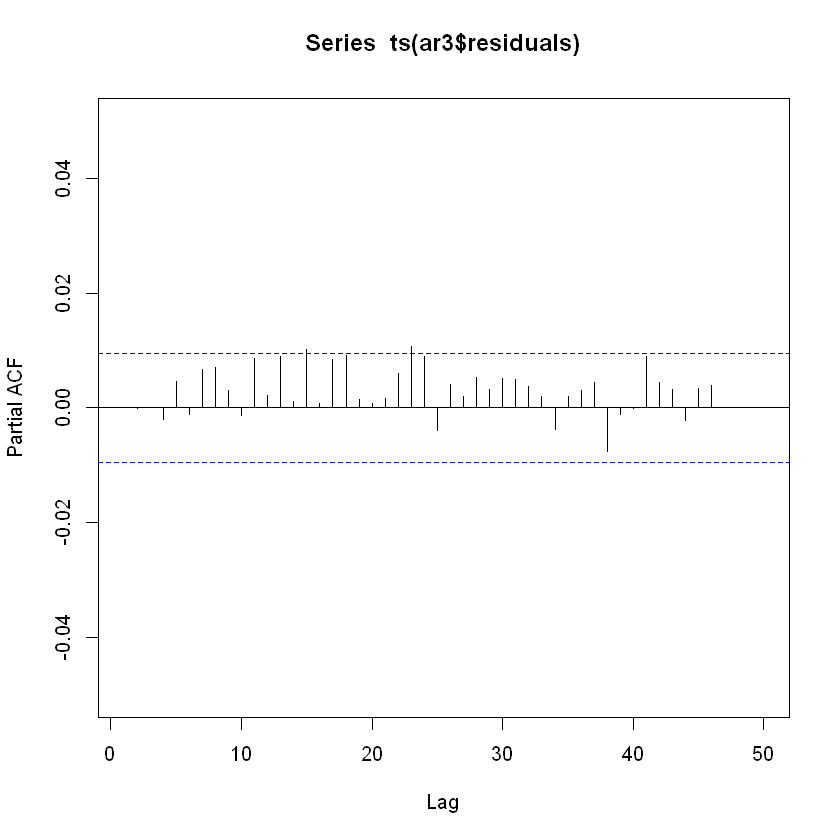

In [88]:
pacf(ts(ar2$residuals), xlim=c(1,50), ylim = c(-0.05, 0.05))
pacf(ts(ar3$residuals), xlim=c(1,50), ylim = c(-0.05, 0.05))
str(pacf_obj)
# cpgram(ar3$residuals)

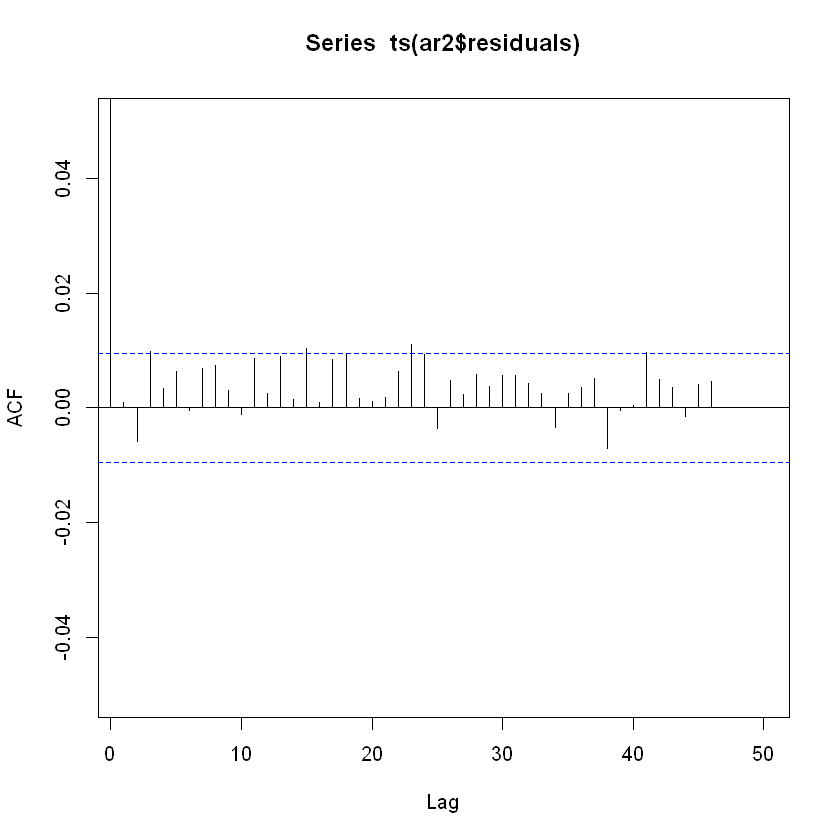

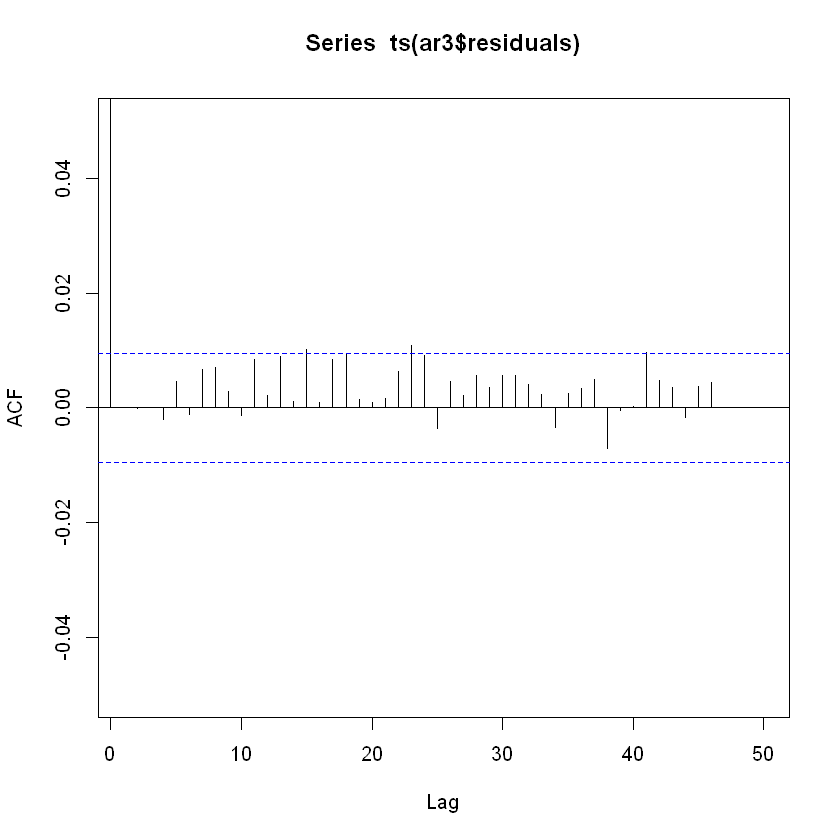

In [89]:
acf(ts(ar2$residuals), xlim=c(1,50), ylim = c(-0.05, 0.05))
acf(ts(ar3$residuals), xlim=c(1,50), ylim = c(-0.05, 0.05))

In [51]:
str(ar2)

List of 18
 $ coef     : Named num [1:3] 5.00e-01 -7.73e-02 3.13e-08
  ..- attr(*, "names")= chr [1:3] "ar1" "ar2" "intercept"
 $ sigma2   : num 0.773
 $ var.coef : num [1:3, 1:3] 2.35e-05 -1.09e-05 -2.29e-10 -1.09e-05 2.35e-05 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:3] "ar1" "ar2" "intercept"
  .. ..$ : chr [1:3] "ar1" "ar2" "intercept"
 $ mask     : logi [1:3] TRUE TRUE TRUE
 $ loglik   : num -54626
 $ aic      : num 109261
 $ arma     : int [1:7] 2 0 0 0 365 0 0
 $ residuals: Time-Series [1:42340] from 1 to 117: -0.00362 -0.51359 0.08699 -0.70679 1.91585 ...
 $ call     : language Arima(y = ts, order = c(2, 0, 0))
 $ series   : chr "ts"
 $ code     : int 0
 $ n.cond   : int 0
 $ nobs     : int 42340
 $ model    :List of 10
  ..$ phi  : num [1:2] 0.5002 -0.0773
  ..$ theta: num 0
  ..$ Delta: num(0) 
  ..$ Z    : num [1:2] 1 0
  ..$ a    : num [1:2] -0.8852 -0.0621
  ..$ P    : num [1:2, 1:2] 0 0 0 0
  ..$ T    : num [1:2, 1:2] 0.5002 -0.0773 1 0
  ..$ V    : num [1

In [54]:
plot(ar2$fitted)

[1] 116

In [31]:
summary(ar2)
summary(ar3)

Series: ts 
ARIMA(2,0,0) with non-zero mean 

Coefficients:
         ar1      ar2    mean
      0.5002  -0.0773  0.0000
s.e.  0.0048   0.0048  0.0074

sigma^2 estimated as 0.773:  log likelihood=-54626.27
AIC=109260.5   AICc=109260.5   BIC=109295.2

Training set error measures:
                        ME      RMSE       MAE      MPE     MAPE      MASE
Training set -1.028133e-05 0.8791846 0.7056986 99.18318 234.0203 0.6320992
                    ACF1
Training set 0.000999539
Series: ts 
ARIMA(3,0,0) with non-zero mean 

Coefficients:
         ar1      ar2     ar3    mean
      0.5012  -0.0837  0.0128  0.0000
s.e.  0.0049   0.0054  0.0049  0.0075

sigma^2 estimated as 0.7729:  log likelihood=-54622.81
AIC=109255.6   AICc=109255.6   BIC=109298.9

Training set error measures:
                        ME      RMSE       MAE     MPE     MAPE      MASE
Training set -1.020934e-05 0.8791127 0.7058104 99.7468 234.3031 0.6321994
                     ACF1
Training set 3.147659e-06


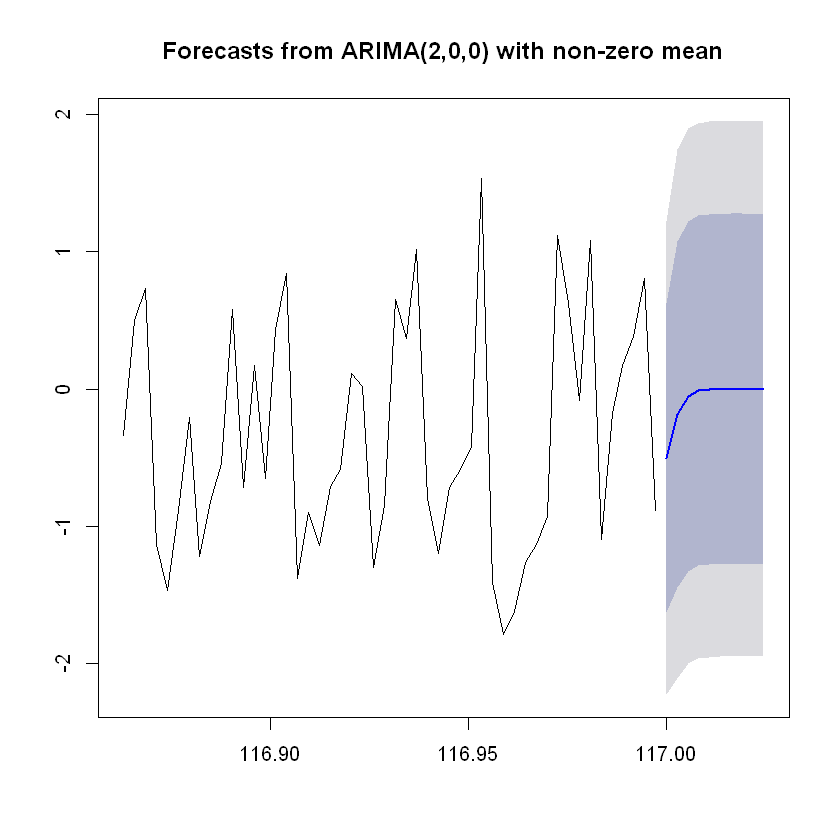

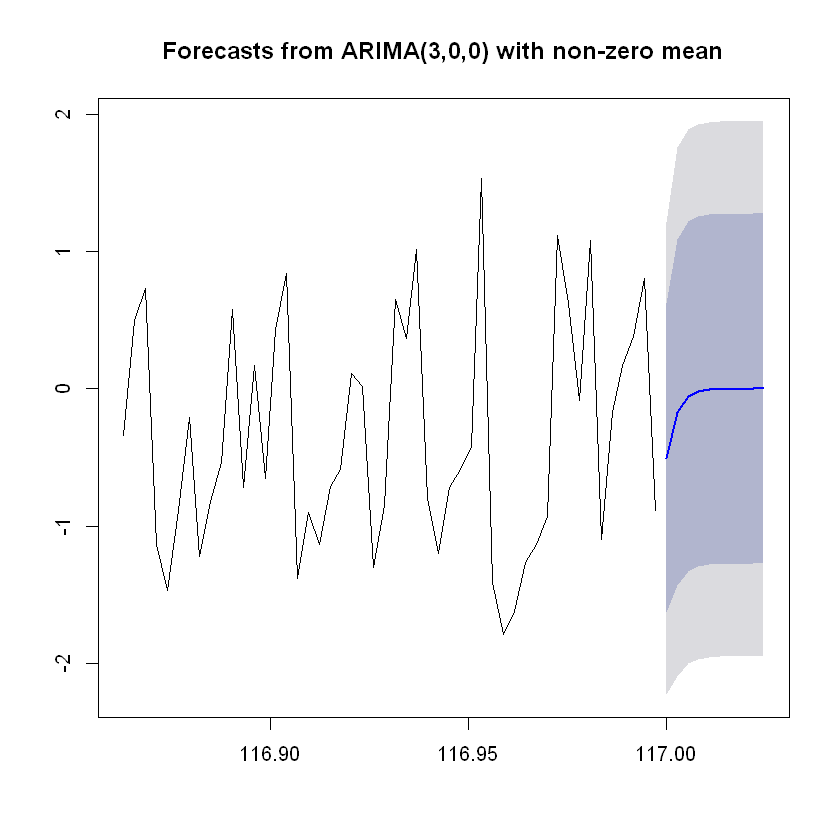

In [99]:
ar2_forecast <- forecast(ar2, h=10)
plot(ar2_forecast, include = 50)

ar3_forecast <- forecast(ar3, h=10)
plot(ar3_forecast, include = 50)

# predict(ar2, ahead = 10)

# ar3_forecast <- forecast(ar3)
# plot(ar3_forecast)

In [90]:
str(ar2_forecast)

List of 10
 $ method   : chr "ARIMA(2,0,0) with non-zero mean"
 $ model    :List of 18
  ..$ coef     : Named num [1:3] 5.00e-01 -7.73e-02 3.13e-08
  .. ..- attr(*, "names")= chr [1:3] "ar1" "ar2" "intercept"
  ..$ sigma2   : num 0.773
  ..$ var.coef : num [1:3, 1:3] 2.35e-05 -1.09e-05 -2.29e-10 -1.09e-05 2.35e-05 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:3] "ar1" "ar2" "intercept"
  .. .. ..$ : chr [1:3] "ar1" "ar2" "intercept"
  ..$ mask     : logi [1:3] TRUE TRUE TRUE
  ..$ loglik   : num -54626
  ..$ aic      : num 109261
  ..$ arma     : int [1:7] 2 0 0 0 365 0 0
  ..$ residuals: Time-Series [1:42340] from 1 to 117: -0.00362 -0.51359 0.08699 -0.70679 1.91585 ...
  ..$ call     : language Arima(y = ts, order = c(2, 0, 0))
  ..$ series   : chr "ts"
  ..$ code     : int 0
  ..$ n.cond   : int 0
  ..$ nobs     : int 42340
  ..$ model    :List of 10
  .. ..$ phi  : num [1:2] 0.5002 -0.0773
  .. ..$ theta: num 0
  .. ..$ Delta: num(0) 
  .. ..$ Z    : num [1:2] 1 0

In [50]:
ts

Time Series:
Start = c(1, 1) 
End = c(116, 365) 
Frequency = 365 
    [1] -4.104783e-03 -5.170393e-01 -1.713382e-01 -7.525152e-01  1.552664e+00
    [6] -2.135108e-01  4.706441e-01 -6.545013e-01 -8.262827e-01 -2.713578e-01
   [11]  4.246006e-01  3.542048e-01 -9.093671e-02 -3.136722e-01 -1.292197e+00
   [16] -1.160666e+00 -9.063479e-01  7.166027e-01 -6.240963e-01 -7.391160e-01
   [21] -1.520897e+00 -1.070458e+00 -4.808251e-01  9.805516e-01  9.999327e-01
   [26]  9.894714e-01  1.247067e+00  2.015516e+00 -8.305304e-01 -8.683295e-01
   [31]  5.240555e-01  8.160449e-01 -7.094848e-01 -8.312205e-01  4.600623e-01
   [36]  6.574374e-01  1.052294e+00  1.344930e+00 -7.885111e-01  2.939971e-01
   [41]  5.029417e-01 -2.478495e-01 -4.656889e-01 -3.590248e-01  1.778872e-01
   [46] -5.995005e-01 -1.056402e+00 -9.299212e-01 -5.682493e-02 -3.723813e-01
   [51] -1.060216e-01  6.899778e-01 -7.897990e-02 -9.806635e-01 -1.020366e+00
   [56] -5.380531e-01 -6.325113e-01 -9.375781e-01  5.979611e-02  6.837471e-0